In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline
import numpy as np
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample,choices
from scipy.stats import pearsonr
# sns.set_style("whitegrid")
sns.set(rc={"lines.linewidth": 2})

def replicateCorrs(inDf,pertColName,featColNames,plotEnabled):

    """
    Calculates replicate correlation versus across purtburtion correlations

    This function takes the input dataframe and output/plot replicate correlations.

    Parameters:
    inDf   (pandas df): input dataframe contains metadata and features
    pertColName  (str): The column based on which we define replicates of a purturbation
    featColNames(list): The list of all columns corresponding to features
    plotEnabled (bool): If True or 1, plots the curves

    Returns:
    repCorrDf   (list):

    """


    df=inDf.copy()
    df[featColNames]=inDf[featColNames].interpolate();
    uniqPert=df[pertColName].unique().tolist()
    repC=[]
    randC=[]

    repCorrDf=pd.DataFrame(index = uniqPert,columns=['RepCor'])

    repSizeDF=df.groupby([pertColName]).size().reset_index()
    highRepComp=repSizeDF[repSizeDF[0]>1][pertColName].tolist()


    for u in highRepComp:
        df1=df[df[pertColName]==u].drop_duplicates().reset_index(drop=True)
        repCorrPurtbs=df1.loc[:,featColNames].T.corr()
        repCorr=list(repCorrPurtbs.values[np.triu_indices(repCorrPurtbs.shape[0], k = 1)])
        repCorrDf.loc[u,'RepCor']=np.nanmean(repCorr)
        repC=repC+[np.nanmedian(repCorr)]

    randC_v2=[]
    for i in range(50):
        uniqeSamplesFromEachPurt=inDf.groupby(pertColName)[featColNames].apply(lambda s: s.sample(1))
        corrMatAcrossPurtbs=uniqeSamplesFromEachPurt.loc[:,featColNames].T.corr()
        randCorrVals=list(corrMatAcrossPurtbs.values[np.triu_indices(corrMatAcrossPurtbs.shape[0], k = 1)])
    randC_v2=randC_v2+randCorrVals

    if 0:
        fig, axes = plt.subplots(figsize=(5,3))
        sns.kdeplot(randC, bw=.1, label="random pairs",ax=axes)
        sns.kdeplot(repC, bw=.1, label="replicate pairs",ax=axes);axes.set_xlabel('CC');
        sns.kdeplot(randC_v2, bw=.1, label="random v2 pairs",ax=axes);axes.set_xlabel('CC');
#         perc5=np.percentile(repCC, 50);axes.axvline(x=perc5,linestyle=':',color='darkorange');
#         perc95=np.percentile(randCC, 90);axes.axvline(x=perc95,linestyle=':');
        axes.legend();#axes.set_title('');
        axes.set_xlim(-1.1,1.1)

    repC = [repC for repC in repC if str(repC) != 'nan']
    randC_v2 = [randC_v2 for randC_v2 in randC_v2 if str(randC_v2) != 'nan']

    perc95=np.percentile(randC_v2, 90);
    rep10=np.percentile(repC, 10);

    if plotEnabled:
        fig, axes = plt.subplots(figsize=(5,4))

        sns.distplot(randC_v2,kde=True,hist=True,bins=20,label="random pairs",ax=axes,norm_hist=True);
        sns.distplot(repC,kde=True,hist=True,bins=20,label="replicate pairs",ax=axes,norm_hist=True,color='r');

        #         perc5=np.percentile(repCC, 50);axes.axvline(x=perc5,linestyle=':',color='darkorange');
        axes.axvline(x=perc95,linestyle=':');
        axes.axvline(x=0,linestyle=':');
        axes.legend(loc=2);#axes.set_title('');
        # axes.set_xlim(-1,1);
        plt.tight_layout()

    repCorrDf['Rand90Perc']=perc95
    repCorrDf['Rep10Perc']=rep10

    return [randC_v2,repC,repCorrDf]

In this notebook the Percent Replicating score for DMSO at each position is computed for the following U2OS 48h time point compound plates
1. Whole plate normalized CP profiles
2. Spherized CP profiles
3. Spherized DL profiles

The following are the steps taken
1. Whole plate normalized CP profiles, Spherized CP profiles and Spherized DL profiles from the 48h Compound experiment are read and the replicates plates merged into a single dataframe.
2. All the non-negative control wells are removed.
3. DMSO wells in the same position are considered replicates while DMSO wells in different positions are considered non-replicates.
4. The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
5. The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
6. Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution
7. The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.

# CP base

In [2]:
df_base = pd.read_csv('/Users/mbornhol/git/neural-profiling/baseline/01_data/level_3_data/2016_04_01_a549_48hr_batch1_dmso_spherized_profiles_with_input_normalized_by_dmso.csv.gz')
df_base_dmso = df_base.query("Metadata_broad_sample == 'DMSO'")

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


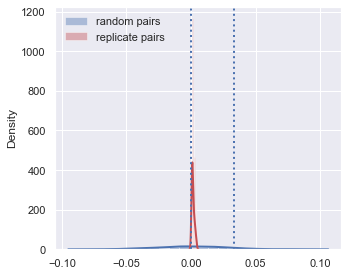

In [17]:
features = [f for f in df_base.columns if not f.startswith("Meta")]
randC_v2,repC,repCorrDf = replicateCorrs(df_base_dmso, "Metadata_Well",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')

In [18]:
print(prop_95_replicating)
print(value_95_replicating)

0.0
0.0418984213466351


In [19]:
repC

[0.0027081297112408432,
 0.0011681215839064757,
 0.0006092082287695777,
 0.0009202431429691509,
 0.001871821360730351,
 0.0010071087620965764,
 0.003542571512729198,
 0.003047202605465587,
 0.004083832455313052,
 0.002784756232287063,
 0.0020835467308742556,
 0.0020495457497042746,
 0.0010138425437150045,
 0.0005296613529982612,
 0.0012020609158485554,
 0.0005100150300069651,
 0.0007927514960578475,
 0.0006512639179461575,
 0.0013683413456418055,
 0.0010604606103065363,
 0.0011669232052182589,
 0.0007654364384513496,
 0.00113346295267247,
 0.0019886083211072955]

# pretrained
1. without norm
2. With Mad rob
3. With sphere

In [38]:
df_eff = pd.read_csv('/Users/mbornhol/git/neural-profiling/00_thesis/pre_trained/aggregated_efficientnet_median.csv')
features = [f for f in df_eff.columns if not f.startswith("Meta")]
df_eff_mad = normalize(
    profiles=df_eff,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
).query("Metadata_broad_sample == 'DMSO'")

df_eff_sph = normalize(
    profiles=df_eff,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
).query("Metadata_broad_sample == 'DMSO'")
df_eff = df_eff.query("Metadata_broad_sample != 'DMSO'")

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0
0.9999997195417636


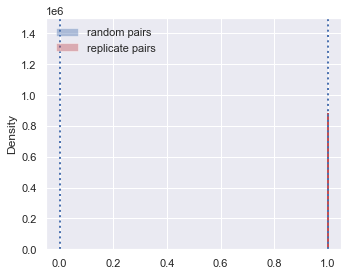

In [39]:
randC_v2,repC,repCorrDf = replicateCorrs(df_eff, "Metadata_Well",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')
print(prop_95_replicating)
print(value_95_replicating)

In [43]:
replicating_corr = list(utils.corr_between_replicates(df_eff, "Metadata_Well")) # signal distribution
null_replicating = list(utils.corr_between_non_replicates(df_eff, n_samples=100, n_replicates=10, metadata_compound_name = "Metadata_Well")) # null distribution
prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating,replicating_corr, how='right')
print(prop_95_replicating)
print(value_95_replicating)

0.0
0.9999988896318021


/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0
0.6304089355049526


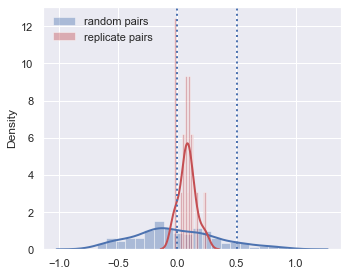

In [7]:
randC_v2,repC,repCorrDf = replicateCorrs(df_eff_mad, "Metadata_Well",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')
print(prop_95_replicating)
print(value_95_replicating)

0.0
0.000320179162640579


/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


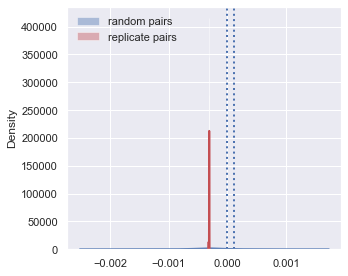

In [8]:
randC_v2,repC,repCorrDf = replicateCorrs(df_eff_sph, "Metadata_Well",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')
print(prop_95_replicating)
print(value_95_replicating)

In [13]:
df_train = pd.read_csv('/Users/mbornhol/git/neural-profiling/training/runs/813/813_aggregated_median.csv')
df_train_dmso = df_train.query("Metadata_broad_sample == 'DMSO'")
features = [f for f in df_train.columns if not f.startswith("Meta")]

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0
0.9999491218070883


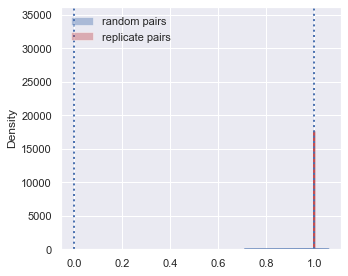

In [14]:
randC_v2,repC,repCorrDf = replicateCorrs(df_train_dmso, "Metadata_Well",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')
print(prop_95_replicating)
print(value_95_replicating)

In [70]:
value_95_replicating

0.9999974568509163

0.044596996517038134

In [4]:
df_eff = pd.read_csv('/Users/mbornhol/git/neural-profiling/00_thesis/pre_trained/aggregated_efficientnet_median.csv')
df_eff_dmso = df_eff.query("Metadata_broad_sample == 'DMSO'")
features = [f for f in df_eff_dmso.columns if not f.startswith("Meta")]
randC_v2,repC,repCorrDf = replicateCorrs(df_eff_dmso, "Metadata_Well",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


NameError: name 'replicateCorrs' is not defined

In [71]:
# plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
value_95_replicating

0.9999974568509163

In [20]:
df_base = pd.read_csv('/Users/mbornhol/git/neural-profiling/baseline/01_data/level_3_data/2016_04_01_a549_48hr_batch1_dmso_spherized_profiles_with_input_normalized_by_dmso.csv.gz')

/Users/mbornhol/miniconda3/envs/cyto_eval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
df_base = df_base.query("Metadata_broad_sample != 'DMSO'")
df_base = df_base [df_base_dmso.Metadata_plate_map_name == "C-7161-01-LM6-027"]

In [21]:
features = [f for f in df_base.columns if not f.startswith("Meta")]
randC_v2,repC,repCorrDf = replicateCorrs(df_base_dmso, "Metadata_broad_sample",features,1)
prop_95_replicating, value_95_replicating = utils.percent_score(randC_v2, repC,how='right')

KeyboardInterrupt: 

In [ ]:
print(prop_95_replicating)
print(value_95_replicating)

In [26]:
df_base_dmso.head()

,Metadata_plate_map_name,Metadata_broad_sample,Metadata_mg_per_ml,Metadata_mmoles_per_liter,Metadata_solvent,Metadata_Plate,Metadata_Well,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_pert_well,...,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_SumVariance_RNA_5_0,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Texture_Variance_RNA_5_0
6,C-7161-01-LM6-027,BRD-K92301463-001-05-5,0.380520,1.000000,DMSO,SQ00015211,A07,BRD-K92301463,BRD-K92301463-001-05-5,A07,...,-1.914416,0.956014,-1.555247,-0.038971,0.563998,-0.459078,-0.613771,-1.199368,-1.558536,1.893174
7,C-7161-01-LM6-027,BRD-K92301463-001-05-5,0.126840,0.333330,DMSO,SQ00015211,A08,BRD-K92301463,BRD-K92301463-001-05-5,A08,...,0.278340,-1.466554,1.298892,-0.085553,2.078748,-0.785900,0.834367,1.361300,1.568432,1.296790
8,C-7161-01-LM6-027,BRD-K92301463-001-05-5,0.042280,0.111110,DMSO,SQ00015211,A09,BRD-K92301463,BRD-K92301463-001-05-5,A09,...,2.375923,-1.126536,-2.368054,0.677266,-2.161539,-1.030605,0.131178,-1.475261,2.989612,0.977136
9,C-7161-01-LM6-027,BRD-K92301463-001-05-5,0.014093,0.037037,DMSO,SQ00015211,A10,BRD-K92301463,BRD-K92301463-001-05-5,A10,...,-0.639863,-0.458803,0.052816,-0.986230,0.459197,-0.868973,-0.826204,-0.615738,0.809007,1.710367
10,C-7161-01-LM6-027,BRD-K92301463-001-05-5,0.004698,0.012346,DMSO,SQ00015211,A11,BRD-K92301463,BRD-K92301463-001-05-5,A11,...,-0.046652,-0.693108,0.279095,-1.250561,0.244342,0.833477,-0.205147,1.103067,-4.454818,0.335270


In [11]:
features = [f for f in df_eff.columns if not f.startswith("Meta")]
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
rob_DMSO = normalize(
    profiles=df_eff,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
).query("Metadata_broad_sample == 'DMSO'")

,Metadata_Aggregate_On,Metadata_Well_Position,Metadata_Plate,Metadata_Well,Metadata_broad_sample,Metadata_moa,Metadata_mmoles_per_liter,Metadata_dose_recode,Metadata_Concentration,Metadata_Treatment_ID,...,efficientnet_6390,efficientnet_6391,efficientnet_6392,efficientnet_6393,efficientnet_6394,efficientnet_6395,efficientnet_6396,efficientnet_6397,efficientnet_6398,efficientnet_6399
0,well,SQ00014812/A01,SQ00014812,A01,DMSO,unknown,0.0,0,NaN,0,...,-0.877628,0.961319,1.031408,0.181504,0.085185,-0.836756,0.335190,0.623790,-0.701943,-0.106164
1,well,SQ00014812/A02,SQ00014812,A02,DMSO,unknown,0.0,0,NaN,0,...,-0.695168,0.774378,-0.250129,-0.058580,0.237552,-0.922884,0.135440,0.888928,-0.283894,-0.497282
2,well,SQ00014812/A03,SQ00014812,A03,DMSO,unknown,0.0,0,NaN,0,...,-0.697905,0.574986,0.224785,-0.230136,0.271980,-0.531208,-0.129495,0.277405,-0.535411,-0.157726
3,well,SQ00014812/A04,SQ00014812,A04,DMSO,unknown,0.0,0,NaN,0,...,-0.871711,0.544572,-0.072644,-0.142519,0.295878,-1.065528,0.345489,1.282360,-0.669664,-0.545866
4,well,SQ00014812/A05,SQ00014812,A05,DMSO,unknown,0.0,0,NaN,0,...,-1.096220,0.806013,0.690064,-0.001062,0.068451,-0.994238,0.654678,0.901693,-0.773342,-0.316473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3234,well,SQ00015233/J14,SQ00015233,J14,DMSO,unknown,0.0,0,NaN,0,...,-0.247420,0.270666,-0.579819,-0.122932,-0.105427,-0.508268,0.176703,-0.448085,-0.397045,-0.103281
3235,well,SQ00015233/J15,SQ00015233,J15,DMSO,unknown,0.0,0,NaN,0,...,-0.290821,0.047898,-0.307078,-0.231020,0.020180,-0.275306,-0.398989,-0.325250,-0.454847,-0.171000
3236,well,SQ00015233/J16,SQ00015233,J16,DMSO,unknown,0.0,0,NaN,0,...,-0.665908,0.878006,-0.116848,-0.070090,-0.351022,-0.881100,0.809725,-0.377001,-0.482835,-0.129577
3237,well,SQ00015233/J17,SQ00015233,J17,DMSO,unknown,0.0,0,NaN,0,...,-0.795413,1.317973,0.155972,0.091566,-0.261623,-0.933069,0.936062,-0.332777,-0.537313,-0.070764


In [27]:
df_base = df_base [df_base.Metadata_plate_map_name == "C-7161-01-LM6-027"]
replicating_corr = list(utils.corr_between_replicates(df_base, "Metadata_Well")) # signal distribution
null_replicating = list(utils.corr_between_non_replicates(df_base, n_samples=100, n_replicates=10, metadata_compound_name = "Metadata_Well")) # null distribution

In [34]:
prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating,replicating_corr, how='right')

In [35]:
value_95_replicating

0.020211503054496274

In [36]:
prop_95_replicating


66.66666666666666

In [33]:
# replicating_corr

(array([252.,  48.,  11.,  13.,  10.,   8.,  10.,  10.,  16.,   6.]),
 array([-0.02146878,  0.04838175,  0.11823229,  0.18808282,  0.25793336,
         0.32778389,  0.39763442,  0.46748496,  0.53733549,  0.60718603,
         0.67703656]),
 <BarContainer object of 10 artists>)

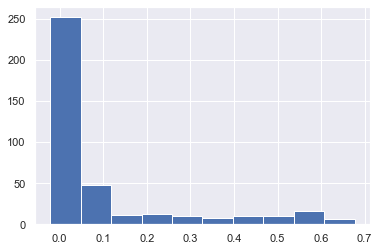

In [32]:
plt.hist(replicating_corr)
